# Préparation de l'environnement pour le chargement des données

In [1]:
from pathlib import Path

## Chargement des bibliothèques de base et création des répertoires de travail

In [2]:
#Importer pandas
import pandas as pd
# instruction permettant d'afficher,
# par défaut, toutes les colonnes d'un dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Téléchargement des données et mise à la disposition de google colab

In [3]:
#Utiliser la mémoire de google drive pour stocker les données et pouvoir faire les calculs
## Télécharger les données depuis l'id du fichier drive.
# train_id = '12LCqi7P3W-waGngWxF3FNP2Lbt9hYU0I' #train 1mdqBCvaVbar1TyuOe5Cg5Grp49TrUnnM
# test_id = '1HjoXeXkOvgDP0vZuJzi1zGpon2wEuwKt' #test
# # Definition des chemins destination  for les fichiers téléchargés
# DATA_DIR = '/home/data/'
# destination_path_1 = Path(DATA_DIR, 'train.csv')
# destination_path_2 = Path(DATA_DIR, 'to_predict.csv')
# !mkdir /home/data/

In [1]:
# # Download the files from Google Drive
# !gdown --id $train_id -O $destination_path_1
# !gdown --id $test_id -O $destination_path_2

In [47]:
# Bibliothques nécessaires
import numpy as np
import pandas as pd
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (balanced_accuracy_score, roc_auc_score,
                             confusion_matrix, classification_report)

# models
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

# Imblearn
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import RandomUnderSampler,TomekLinks
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.metrics import classification_report_imbalanced

## Chargement des données dans le notebook

In [2]:
# final train après EDA
train = pd.read_csv("../bases/train.csv")
train.head(3)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.0,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.0,2,1.0,0.0,184866.69,0


# 1. Préprocessing

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [3]:
X =train.drop(['Exited', 'id', 'CustomerId', 'Surname'], axis = 1)
#X = train.drop(['Exited'], axis = 1) #
y = train['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42 )

del train # Suppression du jeu de donnée de la mémoire

In [4]:
numerical_features = X_train.select_dtypes(include = ['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include = ['object']).columns.tolist()

# 2. Modélisation

In [5]:
models = []
train_auc = []
test_auc = []
cv = StratifiedKFold(n_splits = 3, random_state = 30, shuffle = True)

## 2.1 Modeles

### 2.1.1 Régression logistique

In [6]:
# Preprocessing
ct = ColumnTransformer(
    [
        ('numerical_preprocess', StandardScaler(), numerical_features),
        ('categorical_preprocess', OneHotEncoder(drop = 'first'),categorical_features)
    ]
)

# Pipeline
pipe = Pipeline_imb(
    [
        ('Resampling', RandomUnderSampler(random_state = 42)),
        ('preprocessing', ct),
        ('model', LogisticRegression())
    ]
)

#### Définition d'une fonction pour entrainer les modèles.

Paramètres de rééchantillonnage

In [7]:
# Definition des paramètres d'échantillonage vu que les données sont déséquilibrées.
params_sampler = [
    #  paramètres de sous-échantillonage
    {'randomundersampler__sampling_strategy' : (0.8, 0.7, 0.6),},
   #{'tomeklinks__n_jobs' : (None, 2, 3)},
    {'randomoversampler__sampling_strategy' : (0.4, 0.5, 0.7) },
    # Paramètres de sur-échantillonage
    {'' : ('temp1', 'temp2')},
    #{'adasyn__n_neighbors' : (5, 7, 9) }
]
# L'idée ici est de tester plusieurs paramètres de réechantillonage en vue d'en sélectionner celles qui présentent les meilleurs résultats.

Définition de la fonction proprement dite

In [8]:
def pipelines_and_search(model, params_sampler, params_model, X_train, y_train, cv):
    """
    Crée une liste de pipelines pour le modèle spécifié et effectue une recherche de grille pour chaque pipeline.
    Parameters:
    model (estimator): Le modèle à utiliser dans les pipelines (par exemple, LogisticRegression()).
    params_sampler (list): Liste des paramètres pour les méthodes de rééchantillonnage définie plus haut
    params_model (dict): Dictionnaire des paramètres pour le modèle.
    X_train (array-like): Les données d'entraînement.
    y_train (array-like): Les étiquettes de classe pour les données d'entraînement.
    cv (int or cross-validation generator): La stratégie de validation croisée.

    Returns:
    tuple: Liste des scores et des objets GridSearchCV.
    """
    pipelines = [
        # Méthodes de sous-échantillonnage
        make_pipeline_imb(ct, RandomUnderSampler(random_state=42), model),
        # make_pipeline_imb(ct, TomekLinks(), model),
        make_pipeline_imb(ct, RandomOverSampler(random_state = 42), model),
        # Méthodes de sur-échantillonnage
        make_pipeline_imb(ct, SMOTE(), model),
        # make_pipeline_imb(ct, ADASYN(), model)
    ]

    best_scores = []
    grid_list = []

    for i, pipe in enumerate(pipelines):
        params = params_sampler[i].copy()
        params.update(params_model)
        params.pop('', None)
        print(f"--------------------------------------------------------------------------\n Working on : {params}")

        pipe_GridCV = GridSearchCV(pipe, param_grid=params, cv=cv, scoring='roc_auc')
        grid_list.append(pipe_GridCV)

        pipe_GridCV.fit(X_train, y_train)

        print(f"Best_score : {pipe_GridCV.best_score_}")
        print(f"Best_params : {pipe_GridCV.best_params_}")
        best_scores.append(pipe_GridCV.best_score_)

    return best_scores, grid_list


In [9]:
# Définition des paramètres pour la régression logistique
params_reg_logistic = {#'logisticregression__max_iter' : (1000, 5000),
                'logisticregression__C' : (0.50, 1 ,0.7)
                       }


In [10]:
%%time
log_reg = pipelines_and_search(LogisticRegression(), params_sampler, params_reg_logistic, X_train, y_train, cv)

--------------------------------------------------------------------------
 Working on : {'randomundersampler__sampling_strategy': (0.8, 0.7, 0.6), 'logisticregression__C': (0.5, 1, 0.7)}
Best_score : 0.819535601687436
Best_params : {'logisticregression__C': 0.5, 'randomundersampler__sampling_strategy': 0.8}
--------------------------------------------------------------------------
 Working on : {'randomoversampler__sampling_strategy': (0.4, 0.5, 0.7), 'logisticregression__C': (0.5, 1, 0.7)}
Best_score : 0.8194766030615899
Best_params : {'logisticregression__C': 0.5, 'randomoversampler__sampling_strategy': 0.7}
--------------------------------------------------------------------------
 Working on : {'logisticregression__C': (0.5, 1, 0.7)}
Best_score : 0.8195889194605753
Best_params : {'logisticregression__C': 0.7}
CPU times: total: 1min 11s
Wall time: 1min 6s


In [11]:
# Afficher les meilleurs scores
print("Meilleurs scores pour chaque pipeline :")
for score in log_reg[0]:
    print(score)

Meilleurs scores pour chaque pipeline :
0.819535601687436
0.8194766030615899
0.8195889194605753


In [12]:

# Accéder aux meilleurs paramètres pour chaque GridSearchCV
print("\nMeilleurs paramètres pour chaque pipeline :")
for grid in log_reg[1]:
    print(grid.best_params_)


Meilleurs paramètres pour chaque pipeline :
{'logisticregression__C': 0.5, 'randomundersampler__sampling_strategy': 0.8}
{'logisticregression__C': 0.5, 'randomoversampler__sampling_strategy': 0.7}
{'logisticregression__C': 0.7}


In [13]:
"""
# Accéder aux objets GridSearchCV pour d'autres informations, par exemple :
print("\nDétails complets de chaque GridSearchCV :")
for i, grid in enumerate(log_reg[1]):
    print(f"Pipeline {i+1}:")
    print(f"Best Score: {grid.best_score_}")
    print(f"Best Params: {grid.best_params_}")
    # Accéder aux scores de toutes les combinaisons de paramètres testées
    print(f"CV Results: {grid.cv_results_}")
    """

'\n# Accéder aux objets GridSearchCV pour d\'autres informations, par exemple :\nprint("\nDétails complets de chaque GridSearchCV :")\nfor i, grid in enumerate(log_reg[1]):\n    print(f"Pipeline {i+1}:")\n    print(f"Best Score: {grid.best_score_}")\n    print(f"Best Params: {grid.best_params_}")\n    # Accéder aux scores de toutes les combinaisons de paramètres testées\n    print(f"CV Results: {grid.cv_results_}")\n    '

In [14]:
best_model_index = pd.DataFrame({"Best_score" : log_reg[0]}).sort_values(by = 'Best_score',
                                                                   ascending = False).index[0]
best_model_LG = log_reg[1][best_model_index].best_estimator_
best_model_LG

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_preprocess',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('categorical_preprocess',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('smote', SMOTE()),
                ('logisticregression', LogisticRegression(C=0.7))])

In [15]:
step_names = [name for name, _ in best_model_LG.steps]

train_auc_LG = roc_auc_score(y_train, best_model_LG.predict_proba(X_train)[:, 1])
test_auc_LG = roc_auc_score(y_test, best_model_LG.predict_proba(X_test)[:, 1])
model = step_names[1] + " + " +  step_names[-1]

train_auc.append(train_auc_LG)
test_auc.append(test_auc_LG)
models.append(model)

In [48]:
pd.DataFrame(classification_report_imbalanced(y_test, best_model_LG.predict(X_test), output_dict = True))

,0,1,avg_pre,avg_rec,avg_spe,avg_f1,avg_geo,avg_iba,total_support
pre,0.913213,0.451672,0.815556,0.75535,0.736896,0.77314,0.745951,0.55747,41259
rec,0.762120,0.730126,0.815556,0.75535,0.736896,0.77314,0.745951,0.55747,41259
spe,0.730126,0.762120,0.815556,0.75535,0.736896,0.77314,0.745951,0.55747,41259
f1,0.830853,0.558095,0.815556,0.75535,0.736896,0.77314,0.745951,0.55747,41259
geo,0.745951,0.745951,0.815556,0.75535,0.736896,0.77314,0.745951,0.55747,41259
iba,0.558224,0.554663,0.815556,0.75535,0.736896,0.77314,0.745951,0.55747,41259
sup,32529.000000,8730.000000,0.815556,0.75535,0.736896,0.77314,0.745951,0.55747,41259


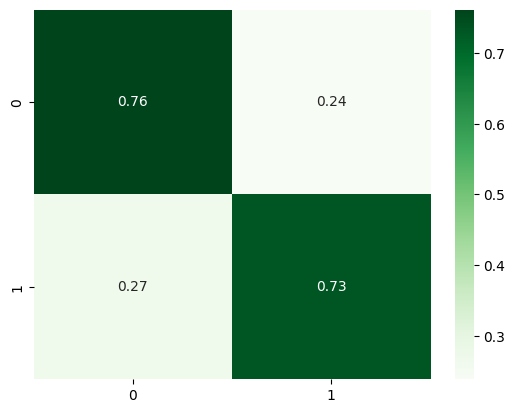

In [48]:
sns.heatmap(confusion_matrix(y_test, best_model_LG.predict(X_test), normalize="true"),
           annot=True, fmt='.2g', cmap="Greens");

### 2.1.2 Naives Bayes

In [35]:
%%time
# Naive Bayes
params_naive_bayes = {'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7]}
naive_bayes = pipelines_and_search(GaussianNB(), params_sampler, params_naive_bayes, X_train, y_train, cv)
#log_reg = pipelines_and_search(LogisticRegression(), params_sampler, params_reg_logistic, X_train, y_train, cv)

--------------------------------------------------------------------------
 Working on : {'randomundersampler__sampling_strategy': (0.8, 0.7, 0.6), 'gaussiannb__var_smoothing': [1e-09, 1e-08, 1e-07]}
Best_score : 0.8179470953839152
Best_params : {'gaussiannb__var_smoothing': 1e-07, 'randomundersampler__sampling_strategy': 0.8}
--------------------------------------------------------------------------
 Working on : {'randomoversampler__sampling_strategy': (0.4, 0.5, 0.7), 'gaussiannb__var_smoothing': [1e-09, 1e-08, 1e-07]}
Best_score : 0.816438218180546
Best_params : {'gaussiannb__var_smoothing': 1e-07, 'randomoversampler__sampling_strategy': 0.5}
--------------------------------------------------------------------------
 Working on : {'gaussiannb__var_smoothing': [1e-09, 1e-08, 1e-07]}
Best_score : 0.8138083559992687
Best_params : {'gaussiannb__var_smoothing': 1e-09}
CPU times: total: 1min
Wall time: 1min 6s


In [36]:
print("Meilleurs scores pour chaque pipeline :")
for score in naive_bayes[0]:
    print(score)

Meilleurs scores pour chaque pipeline :
0.8179470953839152
0.816438218180546
0.8138083559992687


In [37]:
# Accéder aux meilleurs paramètres pour chaque GridSearchCV
print("\nMeilleurs paramètres pour chaque pipeline :")
for grid in naive_bayes[1]:
    print(grid.best_params_)


Meilleurs paramètres pour chaque pipeline :
{'gaussiannb__var_smoothing': 1e-07, 'randomundersampler__sampling_strategy': 0.8}
{'gaussiannb__var_smoothing': 1e-07, 'randomoversampler__sampling_strategy': 0.5}
{'gaussiannb__var_smoothing': 1e-09}


In [39]:
best_model_index = pd.DataFrame({"Best_score" : naive_bayes[0]}).sort_values(by = 'Best_score',
                                                                   ascending = False).index[0]
best_model_NB = naive_bayes[1][best_model_index].best_estimator_
best_model_NB

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_preprocess',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('categorical_preprocess',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('randomundersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.8)),
                ('gaussiannb', GaussianNB(var_smoothing=1e-07))])

In [40]:
step_names = [name for name, _ in best_model_NB.steps]

train_auc_NB = roc_auc_score(y_train, best_model_NB.predict_proba(X_train)[:, 1])
test_auc_NB = roc_auc_score(y_test, best_model_NB.predict_proba(X_test)[:, 1])
model = step_names[1] + " + " +  step_names[-1]

train_auc.append(train_auc_NB)
test_auc.append(test_auc_NB)
models.append(model)

In [41]:
pd.DataFrame(classification_report_imbalanced(y_test, best_model_NB.predict(X_test), output_dict = True))

,0,1,avg_pre,avg_rec,avg_spe,avg_f1,avg_geo,avg_iba,total_support
pre,0.898978,0.452264,0.804457,0.758356,0.695799,0.773582,0.725053,0.52899,41259
rec,0.781303,0.672852,0.804457,0.758356,0.695799,0.773582,0.725053,0.52899,41259
spe,0.672852,0.781303,0.804457,0.758356,0.695799,0.773582,0.725053,0.52899,41259
f1,0.836020,0.540934,0.804457,0.758356,0.695799,0.773582,0.725053,0.52899,41259
geo,0.725053,0.725053,0.804457,0.758356,0.695799,0.773582,0.725053,0.52899,41259
iba,0.531403,0.520000,0.804457,0.758356,0.695799,0.773582,0.725053,0.52899,41259
sup,32529.000000,8730.000000,0.804457,0.758356,0.695799,0.773582,0.725053,0.52899,41259


In [40]:
step_names = [name for name, _ in best_model_NB.steps]

train_auc_NB = roc_auc_score(y_train, best_model_NB.predict_proba(X_train)[:, 1])
test_auc_NB = roc_auc_score(y_test, best_model_NB.predict_proba(X_test)[:, 1])
model = step_names[1] + " + " +  step_names[-1]

train_auc.append(train_auc_NB)
test_auc.append(test_auc_NB)
models.append(model)

In [41]:
pd.DataFrame(classification_report_imbalanced(y_test, best_model_NB.predict(X_test), output_dict = True))

,0,1,avg_pre,avg_rec,avg_spe,avg_f1,avg_geo,avg_iba,total_support
pre,0.898978,0.452264,0.804457,0.758356,0.695799,0.773582,0.725053,0.52899,41259
rec,0.781303,0.672852,0.804457,0.758356,0.695799,0.773582,0.725053,0.52899,41259
spe,0.672852,0.781303,0.804457,0.758356,0.695799,0.773582,0.725053,0.52899,41259
f1,0.836020,0.540934,0.804457,0.758356,0.695799,0.773582,0.725053,0.52899,41259
geo,0.725053,0.725053,0.804457,0.758356,0.695799,0.773582,0.725053,0.52899,41259
iba,0.531403,0.520000,0.804457,0.758356,0.695799,0.773582,0.725053,0.52899,41259
sup,32529.000000,8730.000000,0.804457,0.758356,0.695799,0.773582,0.725053,0.52899,41259


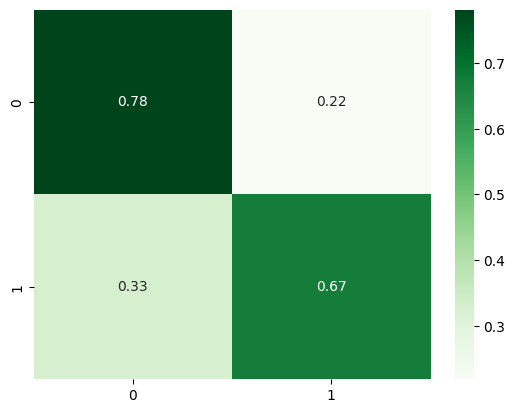

In [50]:
sns.heatmap(confusion_matrix(y_test, best_model_NB.predict(X_test), normalize="true"),
           annot=True, fmt='.2g', cmap="Greens");

### SVM

In [60]:
# SVM
# params_svm = {'svc__C': [0.1, 1, 1.5]}

In [ ]:
# %%time
# svm_model = pipelines_and_search(SVC(probability=True), params_sampler, params_svm, X_train, y_train, cv)

--------------------------------------------------------------------------
 Working on : {'randomundersampler__sampling_strategy': (0.8, 0.7, 0.6), 'svc__C': [0.1, 1, 1.5]}


In [ ]:
# best_model_index = pd.DataFrame({"Best_score" : svm_model[0]}).sort_values(by = 'Best_score',
                                                                   # ascending = False).index[0]
# best_svm_model = svm_model[1][best_model_index].best_estimator_

In [ ]:
# best_svm_model

### Bagging

### 2.1.3 RandomForest

In [ ]:
# %%time
# # Random Forest
# params_random_forest = {'randomforestclassifier__n_estimators': [100, 200, 300]}

In [ ]:
random_forest_model = pipelines_and_search(RandomForestClassifier(), params_sampler, params_random_forest, X_train, y_train, cv)

In [ ]:
best_model_index = pd.DataFrame({"Best_score" : random_forest_model[0]}).sort_values(by = 'Best_score',
                                                                   ascending = False).index[0]
best_random_forest_model = random_forest_model[1][best_model_index].best_estimator_

In [ ]:
best_random_forest_model

### Boosting

In [27]:

# Gradient Boosting
params_gb = {'gradientboostingclassifier__learning_rate': [0.01, 0.1], 'gradientboostingclassifier__max_depth': [3, 4]}


In [28]:
%%time
gradient_boosting_model = pipelines_and_search(GradientBoostingClassifier(), params_sampler, params_gb, X_train, y_train, cv)

--------------------------------------------------------------------------
 Working on : {'randomundersampler__sampling_strategy': (0.8, 0.7, 0.6), 'gradientboostingclassifier__learning_rate': [0.01, 0.1], 'gradientboostingclassifier__max_depth': [3, 4]}


KeyboardInterrupt: 

In [ ]:
best_gradient_boosting_model = pd.DataFrame({"Best_score" : gradient_boosting_model[0]}).sort_values(by = 'Best_score',
                                                                   ascending = False).index[0]
best_gradient_boosting_model = gradient_boosting_model[1][best_model_index].best_estimator_

In [ ]:
best_gradient_boosting_model

### XGBOOST

In [30]:
from xgboost import XGBClassifier
# XGBoost
params_xgboost = {'xgbclassifier__n_estimators': [100, 200], 'xgbclassifier__learning_rate': [0.01, 0.1]}


In [31]:
%%time
xgboost = pipelines_and_search(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), params_sampler, params_xgboost, X_train, y_train, cv)

--------------------------------------------------------------------------
 Working on : {'randomundersampler__sampling_strategy': (0.8, 0.7, 0.6), 'xgbclassifier__n_estimators': [100, 200], 'xgbclassifier__learning_rate': [0.01, 0.1]}
Best_score : 0.8874559684859112
Best_params : {'randomundersampler__sampling_strategy': 0.6, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100}
--------------------------------------------------------------------------
 Working on : {'randomoversampler__sampling_strategy': (0.4, 0.5, 0.7), 'xgbclassifier__n_estimators': [100, 200], 'xgbclassifier__learning_rate': [0.01, 0.1]}
Best_score : 0.8878167144158385
Best_params : {'randomoversampler__sampling_strategy': 0.4, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100}
--------------------------------------------------------------------------
 Working on : {'xgbclassifier__n_estimators': [100, 200], 'xgbclassifier__learning_rate': [0.01, 0.1]}
Best_score : 0.88558

In [32]:

best_xgboost_index = pd.DataFrame({"Best_score" : xgboost[0]}).sort_values(by = 'Best_score',
                                                                   ascending = False).index[0]
best_xgboost = xgboost[1][best_xgboost_index].best_estimator_

In [33]:
best_xgboost

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_preprocess',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('categorical_preprocess',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('randomoversampler',
                 RandomOverSampler(random_state=42...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [52]:
step_names = [name for name, _ in best_xgboost.steps]

train_auc_XGB = roc_auc_score(y_train, best_xgboost.predict_proba(X_train)[:, 1])
test_auc_XGB = roc_auc_score(y_test, best_xgboost.predict_proba(X_test)[:, 1])
model = step_names[1] + " + " +  step_names[-1]

train_auc.append(train_auc_XGB)
test_auc.append(test_auc_XGB)
models.append(model)

In [55]:
pd.DataFrame(classification_report_imbalanced(y_test, best_xgboost.predict(X_test), output_dict = True))

,0,1,avg_pre,avg_rec,avg_spe,avg_f1,avg_geo,avg_iba,total_support
pre,0.902113,0.692171,0.857691,0.861945,0.68924,0.85935,0.761007,0.589134,41259
rec,0.925297,0.625888,0.857691,0.861945,0.68924,0.85935,0.761007,0.589134,41259
spe,0.625888,0.925297,0.857691,0.861945,0.68924,0.85935,0.761007,0.589134,41259
f1,0.913558,0.657363,0.857691,0.861945,0.68924,0.85935,0.761007,0.589134,41259
geo,0.761007,0.761007,0.857691,0.861945,0.68924,0.85935,0.761007,0.589134,41259
iba,0.596472,0.561793,0.857691,0.861945,0.68924,0.85935,0.761007,0.589134,41259
sup,32529.000000,8730.000000,0.857691,0.861945,0.68924,0.85935,0.761007,0.589134,41259


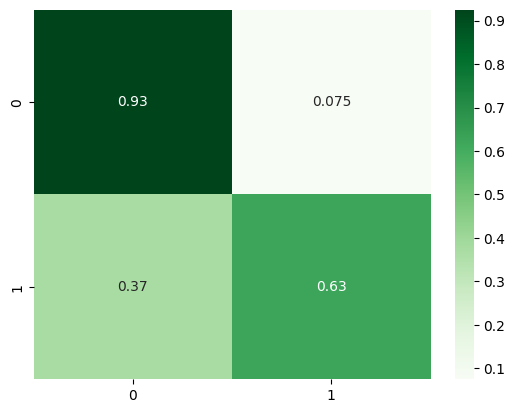

In [56]:
sns.heatmap(confusion_matrix(y_test, best_xgboost.predict(X_test), normalize="true"),
           annot=True, fmt='.2g', cmap="Greens");

### LightGBM

In [42]:
# LightGBM
params_lgbm = {'lgbmclassifier__learning_rate': [0.01, 0.1, 0.05]}

In [43]:
%%time
lightgbm_model = pipelines_and_search(LGBMClassifier(), params_sampler, params_lgbm, X_train, y_train, cv)

--------------------------------------------------------------------------
 Working on : {'randomundersampler__sampling_strategy': (0.8, 0.7, 0.6), 'lgbmclassifier__learning_rate': [0.01, 0.1, 0.05]}
[LightGBM] [Info] Number of positive: 17460, number of negative: 21825
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 39285, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Info] Number of positive: 17461, number of negative: 21826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if mem

In [44]:
best_lightgbm_model = pd.DataFrame({"Best_score" : lightgbm_model[0]}).sort_values(by = 'Best_score',
                                                                   ascending = False).index[0]
best_lightgbm_model = lightgbm_model[1][best_model_index].best_estimator_

In [57]:
best_lightgbm_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_preprocess',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('categorical_preprocess',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('randomundersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.6)),
                ('lgbmclassifier', LGBMClassifier(learning_rate=0.05))])

In [60]:
step_names = [name for name, _ in best_lightgbm_model.steps]

train_auc_LGB = roc_auc_score(y_train, best_lightgbm_model.predict_proba(X_train)[:, 1])
test_auc_LGB = roc_auc_score(y_test, best_lightgbm_model.predict_proba(X_test)[:, 1])
model = step_names[1] + " + " +  step_names[-1]

train_auc.append(train_auc_LGB)
test_auc.append(test_auc_LGB)
models.append(model)

In [61]:
pd.DataFrame(classification_report_imbalanced(y_test, best_lightgbm_model.predict(X_test), output_dict = True))

,0,1,avg_pre,avg_rec,avg_spe,avg_f1,avg_geo,avg_iba,total_support
pre,0.917832,0.627105,0.856317,0.848785,0.74278,0.851883,0.790459,0.631449,41259
rec,0.887669,0.703895,0.856317,0.848785,0.74278,0.851883,0.790459,0.631449,41259
spe,0.703895,0.887669,0.856317,0.848785,0.74278,0.851883,0.790459,0.631449,41259
f1,0.902499,0.663285,0.856317,0.848785,0.74278,0.851883,0.790459,0.631449,41259
geo,0.790459,0.790459,0.856317,0.848785,0.74278,0.851883,0.790459,0.631449,41259
iba,0.636308,0.613343,0.856317,0.848785,0.74278,0.851883,0.790459,0.631449,41259
sup,32529.000000,8730.000000,0.856317,0.848785,0.74278,0.851883,0.790459,0.631449,41259


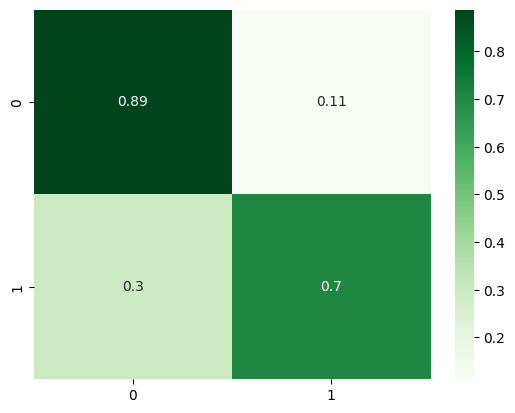

In [62]:
sns.heatmap(confusion_matrix(y_test, best_lightgbm_model.predict(X_test), normalize="true"),
           annot=True, fmt='.2g', cmap="Greens");

### Perceptron

In [64]:
# Perceptron
params_perceptron = {'perceptron__penalty': ['l2', 'l1'], 'perceptron__alpha': [0.001, 0.01]}


In [65]:
perceptron = pipelines_and_search(Perceptron(), params_sampler, params_perceptron, X_train, y_train, cv)

--------------------------------------------------------------------------
 Working on : {'randomundersampler__sampling_strategy': (0.8, 0.7, 0.6), 'perceptron__penalty': ['l2', 'l1'], 'perceptron__alpha': [0.001, 0.01]}
Best_score : 0.7494856586780703
Best_params : {'perceptron__alpha': 0.001, 'perceptron__penalty': 'l1', 'randomundersampler__sampling_strategy': 0.7}
--------------------------------------------------------------------------
 Working on : {'randomoversampler__sampling_strategy': (0.4, 0.5, 0.7), 'perceptron__penalty': ['l2', 'l1'], 'perceptron__alpha': [0.001, 0.01]}
Best_score : 0.7822797670846344
Best_params : {'perceptron__alpha': 0.01, 'perceptron__penalty': 'l1', 'randomoversampler__sampling_strategy': 0.4}
--------------------------------------------------------------------------
 Working on : {'perceptron__penalty': ['l2', 'l1'], 'perceptron__alpha': [0.001, 0.01]}
Best_score : 0.772732448730021
Best_params : {'perceptron__alpha': 0.001, 'perceptron__penalty': '

In [67]:
best_perceptron_model_index = pd.DataFrame({"Best_score" : perceptron[0]}).sort_values(by = 'Best_score',
                                                                   ascending = False).index[0]
best_perceptron_model= perceptron[1][best_perceptron_model_index].best_estimator_

In [68]:
best_perceptron_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_preprocess',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('categorical_preprocess',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('randomoversampler',
                 RandomOverSampler(random_state=42, sampling_strategy=0.4)),
                ('perceptron', Perceptron(alpha=0.01, penalty='l1'))])

In [71]:
"""
step_names = [name for name, _ in best_perceptron_model.steps]

train_auc_perceptron = roc_auc_score(y_train, best_perceptron_model.predict_proba(X_train)[:, 1])
test_auc_perceptron = roc_auc_score(y_test, best_perceptron_model.predict_proba(X_test)[:, 1])
model = step_names[1] + " + " +  step_names[-1]

train_auc.append(train_auc_perceptron)
test_auc.append(test_auc_perceptron)
models.append(model)
"""

# Pas de méthode Predict.proba

'\nstep_names = [name for name, _ in best_perceptron_model.steps]\n\ntrain_auc_perceptron = roc_auc_score(y_train, best_perceptron_model.predict_proba(X_train)[:, 1])\ntest_auc_perceptron = roc_auc_score(y_test, best_perceptron_model.predict_proba(X_test)[:, 1])\nmodel = step_names[1] + " + " +  step_names[-1]\n\ntrain_auc.append(train_auc_perceptron)\ntest_auc.append(test_auc_perceptron)\nmodels.append(model)\n'

In [72]:
pd.DataFrame(classification_report_imbalanced(y_test, best_perceptron_model.predict(X_test), output_dict = True))

,0,1,avg_pre,avg_rec,avg_spe,avg_f1,avg_geo,avg_iba,total_support
pre,0.925097,0.373768,0.808441,0.672944,0.771684,0.702829,0.717225,0.509333,41259
rec,0.636724,0.807904,0.808441,0.672944,0.771684,0.702829,0.717225,0.509333,41259
spe,0.807904,0.636724,0.808441,0.672944,0.771684,0.702829,0.717225,0.509333,41259
f1,0.754288,0.511087,0.808441,0.672944,0.771684,0.702829,0.717225,0.509333,41259
geo,0.717225,0.717225,0.808441,0.672944,0.771684,0.702829,0.717225,0.509333,41259
iba,0.505606,0.523218,0.808441,0.672944,0.771684,0.702829,0.717225,0.509333,41259
sup,32529.000000,8730.000000,0.808441,0.672944,0.771684,0.702829,0.717225,0.509333,41259


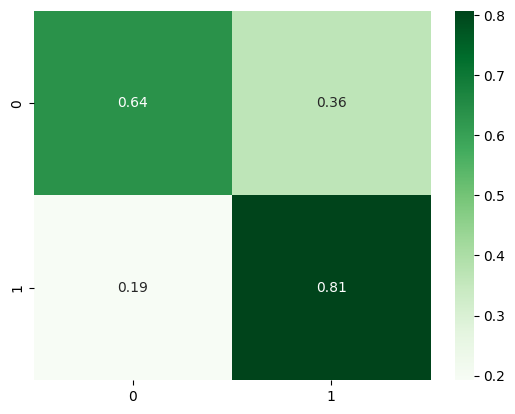

In [70]:
sns.heatmap(confusion_matrix(y_test, best_perceptron_model.predict(X_test), normalize="true"),
           annot=True, fmt='.2g', cmap="Greens");

# Comparaison entre les prédictions du meilleur modèle et celle du voting.

In [73]:
pd.DataFrame({"models" : models, 'train_auc' : train_auc, 'test_auc' : test_auc})

,models,train_auc,test_auc
0,smote + logisticregression,0.819705,0.816132
1,randomundersampler + gaussiannb,0.817122,0.813029
2,randomoversampler + xgbclassifier,0.900426,0.888684
3,randomundersampler + lgbmclassifier,0.892261,0.888668


In [75]:
best_model = best_lightgbm_model
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_preprocess',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('categorical_preprocess',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('randomundersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.6)),
                ('lgbmclassifier', LGBMClassifier(learning_rate=0.05))])

### Exportation du meileur modèle

Après évaluation des différentes combinaisons de modèles et techniques d'échantillonnage, le choix s'est porté sur le modèle utilisant le Random UnderSampler avec LightGBM Classifier. Bien que le modèle avec XGBoost affiche un AUC légèrement supérieur sur l'ensemble d'entraînement (0.900426), le LightGBM présente des performances très proches avec un AUC de 0.892261. De plus, les résultats sur l'ensemble de test sont pratiquement équivalents, avec un AUC de 0.888668 pour LightGBM contre 0.888684 pour XGBoost, indiquant une généralisation similaire. La décision de choisir LightGBM repose sur son efficacité en termes de temps de calcul et de ressources, sa capacité à gérer de très grands ensembles de données et sa flexibilité pour ajuster divers hyperparamètres, ce qui le rend particulièrement adapté à notre environnement et à nos besoins opérationnels.

In [76]:
import pickle

with open('./best_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)